# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [95]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [96]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
1136,HAM_0000796,ISIC_0028415.jpg,mel,histo,60.0,male,trunk,vidir_modern,skin_cancer,malignant,./../data/jpgs/ISIC_0028415.jpg
5408,HAM_0001967,aug_Hy0XD1ISIC_0029860.jpg,akiec,histo,85.0,male,chest,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_Hy0XD1ISIC_0029860.jpg
3467,HAM_0005417,aug_TZaCFVISIC_0027966.jpg,bcc,histo,65.0,male,upper extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_TZaCFVISIC_0027966.jpg
717,HAM_0002859,ISIC_0025119.jpg,nv,follow_up,40.0,male,back,vidir_molemax,not_skin_cancer,benign,./../data/jpgs/ISIC_0025119.jpg
4442,HAM_0003771,aug_ZQPiGtISIC_0025807.jpg,vasc,histo,50.0,female,hand,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_ZQPiGtISIC_0025807.jpg
3126,HAM_0007611,ISIC_0032314.jpg,bcc,histo,85.0,male,back,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0032314.jpg
5369,HAM_0001460,aug_DDjE3BISIC_0025637.jpg,akiec,histo,75.0,male,face,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_DDjE3BISIC_0025637.jpg
2085,HAM_0004423,ISIC_0030318.jpg,bkl,histo,65.0,female,upper extremity,rosendahl,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0030318.jpg
342,HAM_0003029,ISIC_0025685.jpg,nv,follow_up,50.0,female,abdomen,vidir_molemax,not_skin_cancer,benign,./../data/jpgs/ISIC_0025685.jpg
6018,HAM_0007418,ISIC_0031372.jpg,df,consensus,50.0,male,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0031372.jpg


## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [97]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

In [98]:
"""# Augmentation parameters for Randomsearch
horizontal_flip = hp.Boolean("horizontal_flip")
vertical_flip = hp.Boolean("vertical_flip")
zoom_range = hp.Float("zoom_range", min_value=0.0, max_value=0.5)
width_shift_range = hp.Float("width_shift_range", min_value=0.0, max_value=0.5)
height_shift_range = hp.Float("height_shift_range", min_value=0.0, max_value=0.5)
rotation_range = hp.Int("rotation_range", min_value=0, max_value=180)
shear_range = hp.Float("shear_range", min_value=0.0, max_value=0.5)
"""

# Setting up the Image Data Generator for the train and validation data set
datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 7006 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.


In [99]:
def display_dataset_info(train_data_generator, validation_data_generator):
    print(f"Training samples: {train_data_generator.samples}")
    print(f"Validation samples: {validation_data_generator.samples}")
    print(f"Batch size: {train_data_generator.batch_size}")
    print(f"Number of classes: {len(train_data_generator.class_indices)}")

In [100]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


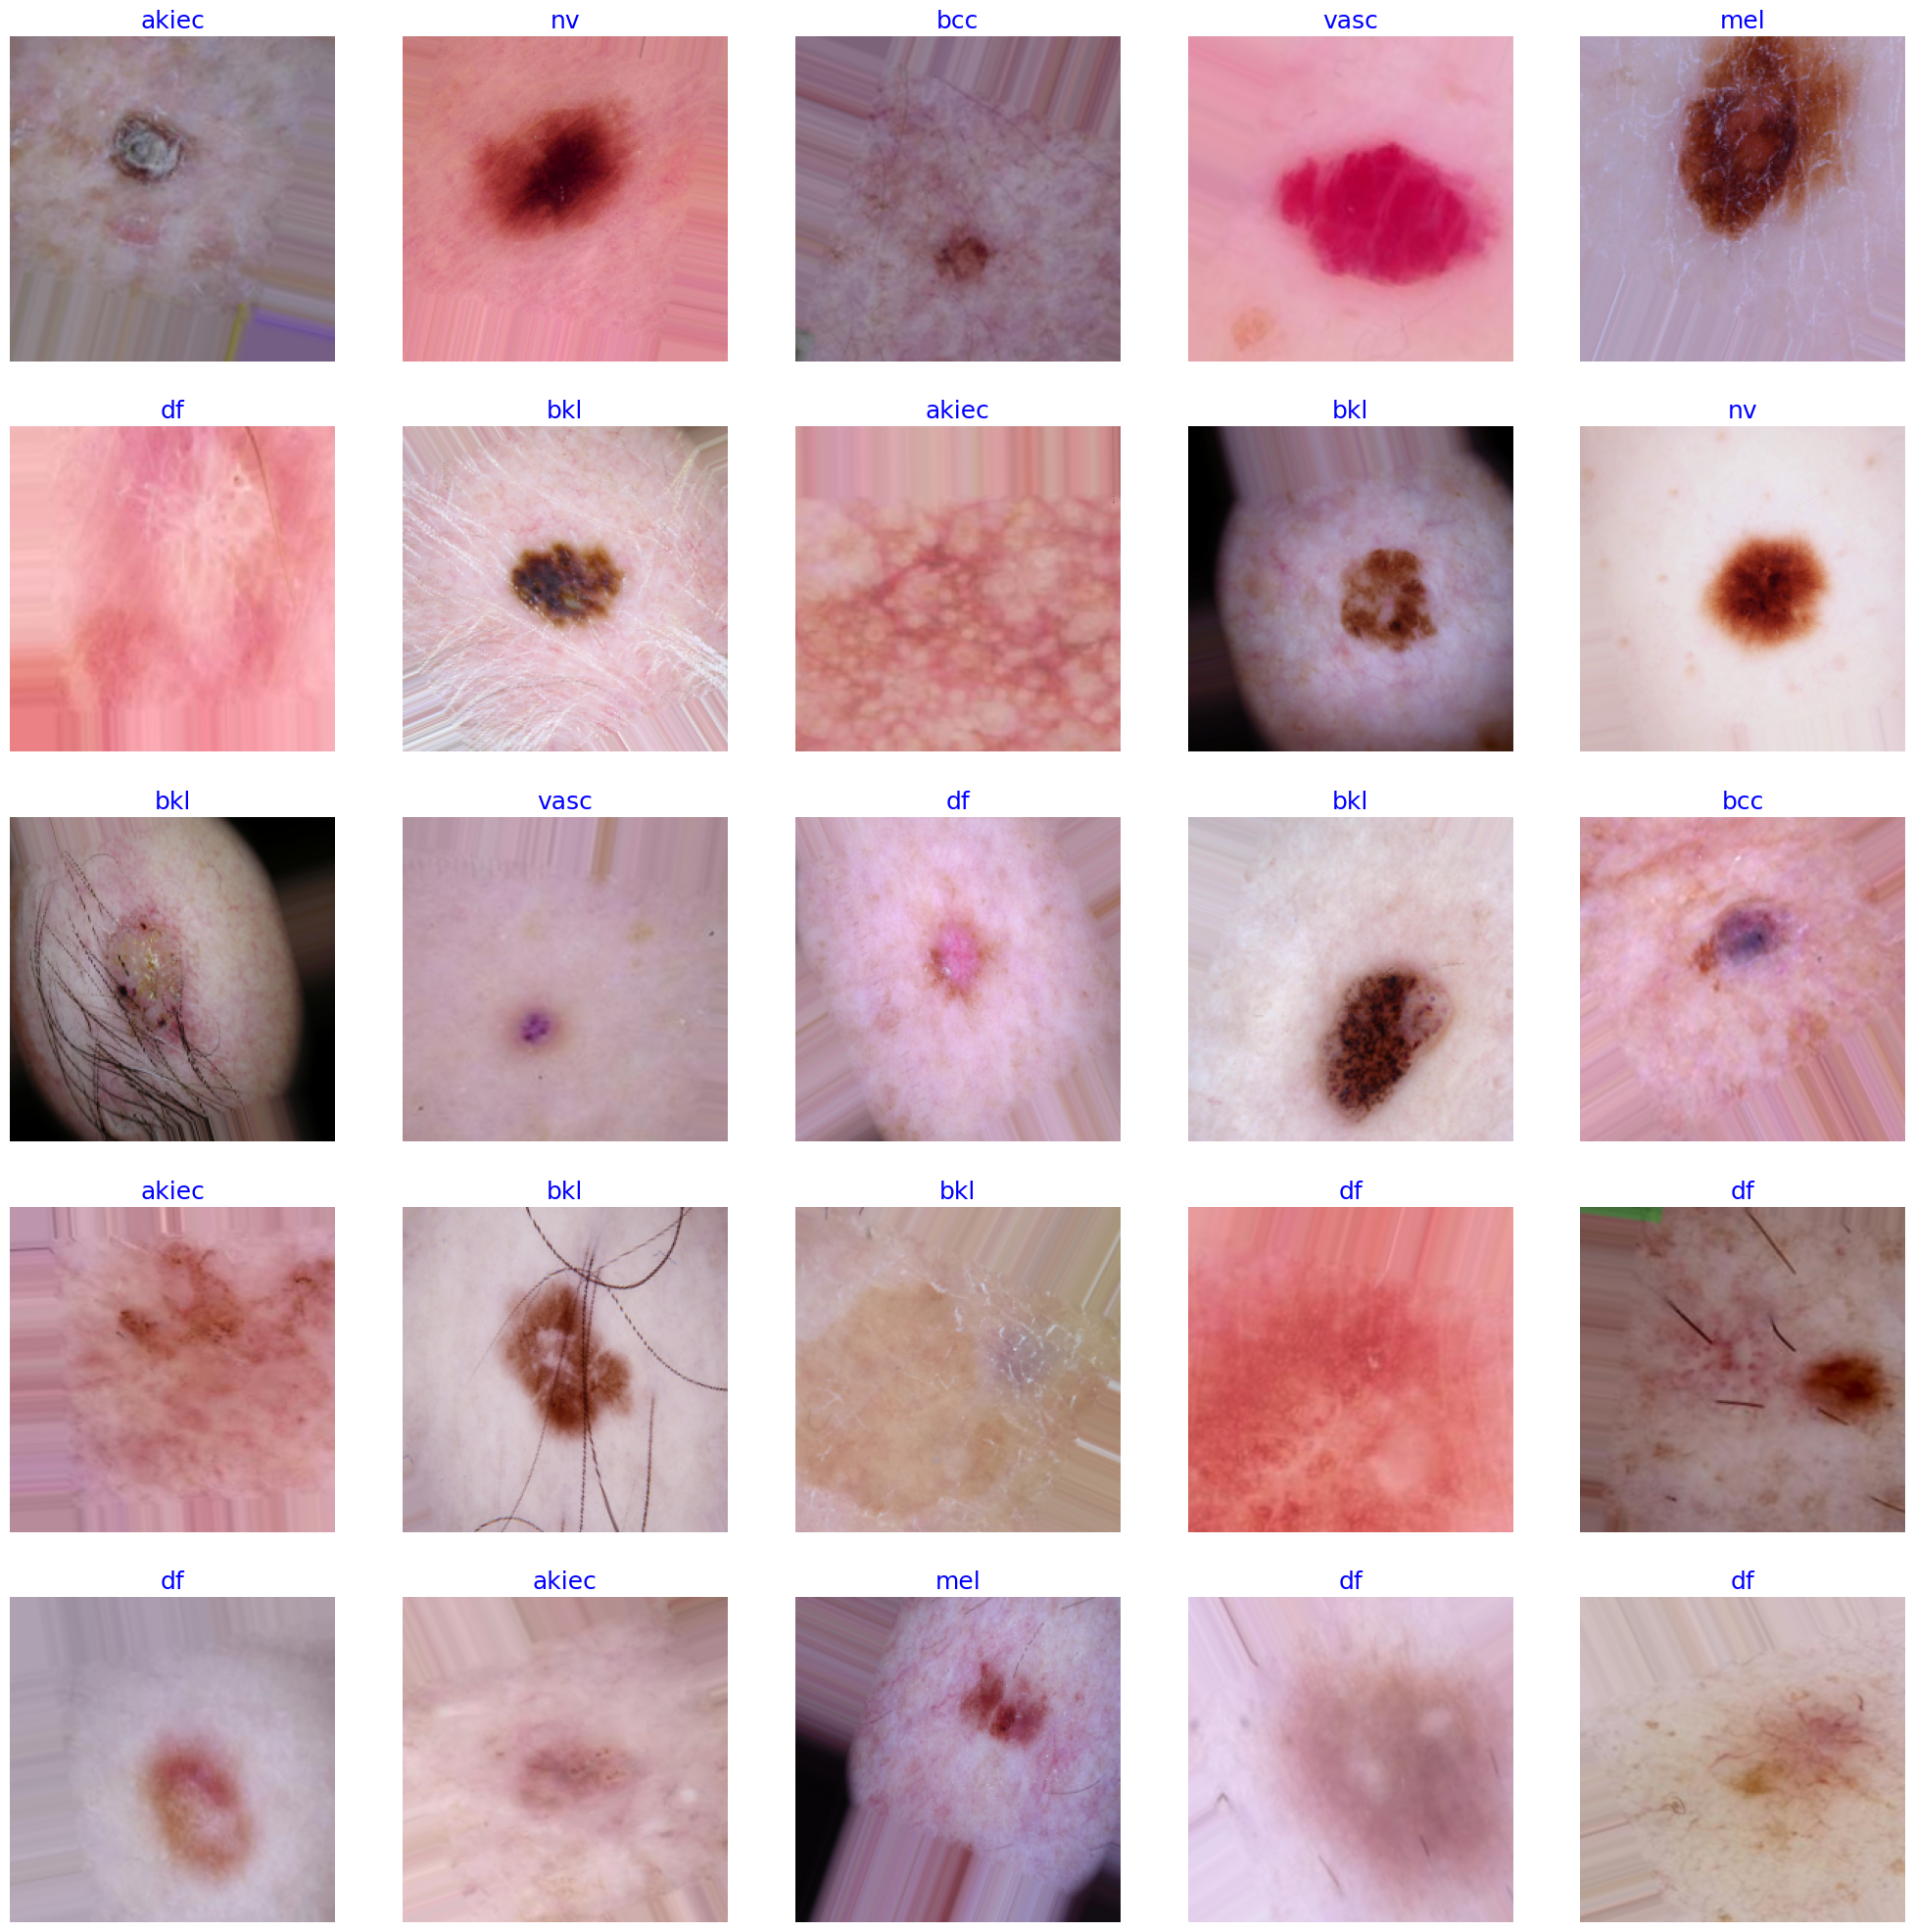

In [101]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [102]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [103]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Class weights 

In [104]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9998572855715713,
 1: 0.9998572855715713,
 2: 0.9998572855715713,
 3: 0.9998572855715713,
 4: 0.9998572855715713,
 5: 1.000857142857143,
 6: 0.9998572855715713}

## Model architecture

In [105]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine import hyperparameters
import math
import tensorflow as tf
from sklearn.utils import class_weight
import os
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy

### Model start - fixed weights - Schnelles und simples Modell zum ersten Versuch

In [106]:
def build_simple_model():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    # (Unverändert, da dies notwendig ist, um die Anzahl der Klassen zu wissen)
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model
    # (Geändert: Wir frieren alle Schichten ein, um das Training zu beschleunigen)
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    
    # (Geändert: Kein Conv2D Layer, da wir ein schnelleres Modell wollen)
    x = GlobalAveragePooling2D()(x)
    
    # (Geändert: Reduzierte Anzahl von Neuronen auf 128 für Schnelligkeit)
    x = Dense(128, activation='relu')(x)
    
    # (Geändert: Kein Dropout, um das Modell schneller zu machen)
    
    # (Unverändert: Softmax für Multiklassen-Klassifikation)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    # (Unverändert: Wir brauchen diese Zeile, um das Modell zu erstellen)
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    # (Geändert: Einfacher Adam Optimizer und nur 'accuracy' als Metrik)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model


### Model01 - Unfreezing Layers - the last 4 layers are trainable

In [107]:
def build_model01():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    # (Unverändert, da dies notwendig ist, um die Anzahl der Klassen zu wissen)
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model
    # (Changed: Only freeze layers except the last 4 to allow fine-tuning)
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    
    # (Geändert: Kein Conv2D Layer, da wir ein schnelleres Modell wollen)
    x = GlobalAveragePooling2D()(x)
    
    # (Geändert: Reduzierte Anzahl von Neuronen auf 128 für Schnelligkeit)
    x = Dense(128, activation='relu')(x)
    
    # (Geändert: Kein Dropout, um das Modell schneller zu machen)
    
    # (Unverändert: Softmax für Multiklassen-Klassifikation)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    # (Unverändert: Wir brauchen diese Zeile, um das Modell zu erstellen)
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model01
    # (Geändert: Einfacher Adam Optimizer und nur 'accuracy' als Metrik)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model


### Model02 - Adding dropout

In [108]:
def build_model02():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    # (Unverändert, da dies notwendig ist, um die Anzahl der Klassen zu wissen)
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model
    # (Changed: Only freeze layers except the last 4 to allow fine-tuning)
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    
    # (Geändert: Kein Conv2D Layer, da wir ein schnelleres Modell wollen)
    x = GlobalAveragePooling2D()(x)
    
    # (Geändert: Reduzierte Anzahl von Neuronen auf 128 für Schnelligkeit)
    x = Dense(128, activation='relu')(x)
    
    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)  # Added this line, 0.5 is the fraction of inputs to drop

    # (Unverändert: Softmax für Multiklassen-Klassifikation)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    # (Unverändert: Wir brauchen diese Zeile, um das Modell zu erstellen)
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model01
    # (Geändert: Einfacher Adam Optimizer und nur 'accuracy' als Metrik)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model


### Model03 - placeholder function for adding class_weights in fitting

In [109]:
def build_model03():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze layers in the base model (except the last 4 for fine-tuning)
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)

    # Final classification layer
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model with class weights (to be added in model.fit)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]  # Include f1_score as a metric
    )
    
    return model


### Model04 - Unfreezing 10 Layers

In [110]:
def build_model04():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    num_classes = len(train_data_generator.class_indices)
    
    # Freeze only the bottom 25 layers
    for layer in base_model.layers[:40]:
        layer.trainable = False
    for layer in base_model.layers[40:]:
        layer.trainable = True
        
    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)

    # Final classification layer
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model with class weights (to be added in model.fit)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]  # Include f1_score as a metric
    )
    
    return model

### Model05: BatchNormalization, increased dropout, lower learning rate

In [111]:
def build_model05():
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes (assuming it's defined in your code)
    num_classes = len(train_data_generator.class_indices)
    
    # Unfreeze layers in the base model (let's unfreeze the last 10 layers for more fine-tuning)
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    # Add custom layers for classification
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    
    x = BatchNormalization()(x)  # Added BatchNormalization for stabilization
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.7)(x)  # Increased Dropout rate to 0.7 to prevent overfitting
    
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)


    # Compile the model with a lower learning rate (0.0001 instead of the default 0.001)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),  # Reduced learning rate for better convergence
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model

### Model06 - Unfreeze 15 layers

In [116]:
def build_model06():
    """
    This function builds and returns a ResNet50-based model with some modifications for the HAM10000 dataset.
    Compared to build_model05, this version uses LegacyAdam optimizer and introduces BatchNormalization.
    """
    # Create a base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Define the number of classes
    num_classes = len(train_data_generator.class_indices)
    
    # Unfreeze layers in the base model (same as build_model05, for fine-tuning)
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output

    # Global Average Pooling Layer (same as build_model05, for reducing dimensions)
    x = GlobalAveragePooling2D()(x)
    
    # Dense Layer with fewer neurons (128) (same as build_model05, for quick training)
    x = Dense(128, activation='relu')(x)
    
    # Dropout layer for regularization (same as build_model05, to prevent overfitting)
    x = Dropout(0.5)(x)

    # Final softmax layer for classification (same as build_model05, for multiclass classification)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model with a lower learning rate (0.0001 instead of the default 0.001)
    # Using LegacyAdam for compatibility with M1/M2 Macs
    model.compile(
        optimizer=LegacyAdam(learning_rate=0.0001),  # Reduced learning rate for better convergence
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_score]
    )

    return model

### Callback functions

#### Learning rate scheduler for model compilation

In [113]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Early stopping

In [114]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_f1_score',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### ModelCheckpoint

In [ ]:
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Pfad, wo das Modell gespeichert wird
    monitor='val_accuracy',  # Metrik, die überwacht wird
    save_best_only=True,  # Nur das beste Modell wird gespeichert
    verbose=1  # Ausgabemodus
)

## Model Training

### Tertiary model

In [ ]:
#tbd 

### simple model

In [107]:
model = build_simple_model()  # Baut das einfache Modell
NUM_EPOCHS = 5  # Zum Beispiel, für ein schnelles Training

# Trainiere das Modell
history = model.fit(
    train_data_generator,  # Trainingsdaten
    epochs=NUM_EPOCHS,  # Anzahl der Epochen
    validation_data=validation_generator,  # Validierungsdaten
    verbose=1  # Ausgabe des Trainingsfortschritts
)


Epoch 1/5


2023-10-09 13:37:05.343978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 2.0052 - accuracy: 0.1332 - f1_score: 0.0000e+00

2023-10-09 13:38:48.378482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 133s 3s/step - loss: 2.0052 - accuracy: 0.1332 - f1_score: 0.0000e+00 - val_loss: 1.7885 - val_accuracy: 0.6623 - val_f1_score: 0.0000e+00
Epoch 2/5
42/42 [==============================] - 111s 3s/step - loss: 1.9698 - accuracy: 0.1452 - f1_score: 0.0000e+00 - val_loss: 2.0182 - val_accuracy: 0.0110 - val_f1_score: 0.0000e+00
Epoch 3/5
42/42 [==============================] - 109s 3s/step - loss: 1.9729 - accuracy: 0.1448 - f1_score: 0.0000e+00 - val_loss: 1.9998 - val_accuracy: 0.0190 - val_f1_score: 0.0000e+00
Epoch 4/5
42/42 [==============================] - 115s 3s/step - loss: 1.9529 - accuracy: 0.1431 - f1_score: 0.0000e+00 - val_loss: 1.8991 - val_accuracy: 0.1638 - val_f1_score: 0.0000e+00
Epoch 5/5
42/42 [==============================] - 119s 3s/step - loss: 1.9544 - accuracy: 0.1473 - f1_score: 0.0000e+00 - val_loss: 1.9679 - val_accuracy: 0.0210 - val_f1_score: 0.0000e+00


### Model01

In [124]:
model = build_model01()  # Baut Modell 01 mit unfrozen layers
NUM_EPOCHS = 5  # Zum Beispiel, für ein schnelles Training

# Trainiere das Modell
history = model.fit(
    train_data_generator,  # Trainingsdaten
    epochs=NUM_EPOCHS,  # Anzahl der Epochen
    validation_data=validation_generator,  # Validierungsdaten
    verbose=1  # Ausgabe des Trainingsfortschritts
)


Epoch 1/5


2023-10-09 13:56:13.969610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 2.0500 - accuracy: 0.1513 - f1_score: 0.0033

2023-10-09 13:57:37.908969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 110s 2s/step - loss: 2.0500 - accuracy: 0.1513 - f1_score: 0.0033 - val_loss: 7.1377 - val_accuracy: 0.0350 - val_f1_score: 0.0350
Epoch 2/5
42/42 [==============================] - 102s 2s/step - loss: 1.9299 - accuracy: 0.1825 - f1_score: 3.6914e-04 - val_loss: 3.7543 - val_accuracy: 0.0579 - val_f1_score: 0.0000e+00
Epoch 3/5
42/42 [==============================] - 137s 3s/step - loss: 1.9188 - accuracy: 0.1945 - f1_score: 3.6914e-04 - val_loss: 2.5987 - val_accuracy: 0.0350 - val_f1_score: 0.0000e+00
Epoch 4/5
42/42 [==============================] - 203s 5s/step - loss: 1.9110 - accuracy: 0.2033 - f1_score: 0.0015 - val_loss: 2.0651 - val_accuracy: 0.0490 - val_f1_score: 0.0000e+00
Epoch 5/5
42/42 [==============================] - 185s 4s/step - loss: 1.8873 - accuracy: 0.2124 - f1_score: 0.0026 - val_loss: 2.2035 - val_accuracy: 0.0400 - val_f1_score: 0.0000e+00


### Model02

In [36]:
model = build_model02()  # Baut Modell 02 mit dropout layers
NUM_EPOCHS = 5  # Zum Beispiel, für ein schnelles Training
display_dataset_info(train_data_generator, validation_data_generator)
# Trainiere das Modell
history = model.fit(
    train_data_generator,  # Trainingsdaten
    epochs=NUM_EPOCHS,  # Anzahl der Epochen
    validation_data=validation_generator,  # Validierungsdaten
    verbose=1  # Ausgabe des Trainingsfortschritts
)


Epoch 1/5


2023-10-09 14:36:33.371107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 2.7500 - accuracy: 0.1420 - f1_score: 0.0776

2023-10-09 14:39:20.187880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 217s 4s/step - loss: 2.7500 - accuracy: 0.1420 - f1_score: 0.0776 - val_loss: 5.4235 - val_accuracy: 0.0509 - val_f1_score: 0.0507
Epoch 2/5
55/55 [==============================] - 297s 5s/step - loss: 2.5528 - accuracy: 0.1539 - f1_score: 0.0657 - val_loss: 2.3903 - val_accuracy: 0.0509 - val_f1_score: 0.0000e+00
Epoch 3/5
55/55 [==============================] - 223s 4s/step - loss: 2.3550 - accuracy: 0.1621 - f1_score: 0.0449 - val_loss: 1.7753 - val_accuracy: 0.0539 - val_f1_score: 0.0000e+00
Epoch 4/5
55/55 [==============================] - 173s 3s/step - loss: 2.2504 - accuracy: 0.1720 - f1_score: 0.0376 - val_loss: 1.6723 - val_accuracy: 0.4166 - val_f1_score: 0.0000e+00
Epoch 5/5
55/55 [==============================] - 163s 3s/step - loss: 2.1448 - accuracy: 0.1758 - f1_score: 0.0231 - val_loss: 1.6916 - val_accuracy: 0.0200 - val_f1_score: 0.0000e+00


### Model03 - implementing class weights

In [38]:
NUM_EPOCHS = 5
model = build_model03()
display_dataset_info(train_data_generator, validation_data_generator)
history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,  # Add this line
    verbose=1
)


Epoch 1/5


2023-10-09 15:05:06.053681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 2.7178 - accuracy: 0.1500 - f1_score: 0.0834

2023-10-09 15:06:39.036881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 118s 2s/step - loss: 2.7178 - accuracy: 0.1500 - f1_score: 0.0834 - val_loss: 1.9392 - val_accuracy: 0.0200 - val_f1_score: 0.0000e+00
Epoch 2/5
55/55 [==============================] - 128s 2s/step - loss: 2.5813 - accuracy: 0.1462 - f1_score: 0.0577 - val_loss: 1.8998 - val_accuracy: 0.0310 - val_f1_score: 0.0000e+00
Epoch 3/5
55/55 [==============================] - 134s 2s/step - loss: 2.3767 - accuracy: 0.1582 - f1_score: 0.0396 - val_loss: 2.1107 - val_accuracy: 0.0170 - val_f1_score: 0.0000e+00
Epoch 4/5
55/55 [==============================] - 138s 2s/step - loss: 2.2523 - accuracy: 0.1643 - f1_score: 0.0227 - val_loss: 2.1141 - val_accuracy: 0.0549 - val_f1_score: 0.0000e+00
Epoch 5/5
55/55 [==============================] - 151s 3s/step - loss: 2.2472 - accuracy: 0.1617 - f1_score: 0.0208 - val_loss: 1.8176 - val_accuracy: 0.3626 - val_f1_score: 0.0000e+00


### Model04 - 40 layers frozen

In [82]:

NUM_EPOCHS = 5
model = build_model04()
display_dataset_info(train_data_generator, validation_generator)
history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,  # Add this line
    verbose=1
)


Training samples: 7006
Validation samples: 1001
Batch size: 32
Number of classes: 7
Epoch 1/5


2023-10-09 16:57:34.509262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 3.4546 - accuracy: 0.1981 - f1_score: 0.1301

2023-10-09 17:01:34.933162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 269s 1s/step - loss: 3.4546 - accuracy: 0.1981 - f1_score: 0.1301 - val_loss: 3.8182 - val_accuracy: 0.0140 - val_f1_score: 0.0137
Epoch 2/5
219/219 [==============================] - 274s 1s/step - loss: 2.1313 - accuracy: 0.2174 - f1_score: 0.0759 - val_loss: 4.7840 - val_accuracy: 0.0140 - val_f1_score: 0.0137
Epoch 3/5
219/219 [==============================] - 283s 1s/step - loss: 1.9514 - accuracy: 0.2164 - f1_score: 0.0530 - val_loss: 10.0908 - val_accuracy: 0.1099 - val_f1_score: 0.1074
Epoch 4/5
219/219 [==============================] - 291s 1s/step - loss: 1.8831 - accuracy: 0.2381 - f1_score: 0.0668 - val_loss: 22.2386 - val_accuracy: 0.1099 - val_f1_score: 0.1149
Epoch 5/5
219/219 [==============================] - 318s 1s/step - loss: 1.8827 - accuracy: 0.2569 - f1_score: 0.0969 - val_loss: 104.9931 - val_accuracy: 0.1099 - val_f1_score: 0.1099


### Model05 - BatchSizeNormalization, Dropout, learningRate

In [90]:
NUM_EPOCHS = 5
model = build_model05()
display_dataset_info(train_data_generator, validation_generator)
history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,  # Add this line
    verbose=1
)

Training samples: 7006
Validation samples: 1001
Batch size: 32
Number of classes: 7
Epoch 1/5


2023-10-09 17:35:24.774589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.2879 - f1_score: 0.1298

2023-10-09 17:37:04.215110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 127s 524ms/step - loss: 1.9954 - accuracy: 0.2879 - f1_score: 0.1298 - val_loss: 3.8861 - val_accuracy: 0.0509 - val_f1_score: 0.0526
Epoch 2/5
219/219 [==============================] - 130s 591ms/step - loss: 1.7842 - accuracy: 0.3491 - f1_score: 0.1961 - val_loss: 5.3066 - val_accuracy: 0.0170 - val_f1_score: 0.0176
Epoch 3/5
219/219 [==============================] - 145s 661ms/step - loss: 1.6998 - accuracy: 0.3919 - f1_score: 0.2403 - val_loss: 2.3063 - val_accuracy: 0.4486 - val_f1_score: 0.4517
Epoch 4/5
219/219 [==============================] - 151s 685ms/step - loss: 1.6025 - accuracy: 0.4116 - f1_score: 0.2871 - val_loss: 3.8796 - val_accuracy: 0.1389 - val_f1_score: 0.1358
Epoch 5/5
219/219 [==============================] - 153s 699ms/step - loss: 1.6347 - accuracy: 0.4242 - f1_score: 0.3149 - val_loss: 10.0715 - val_accuracy: 0.0250 - val_f1_score: 0.0244


### Model06 - Unfreeze 15 layers, earlyStopping, LR_scheduler, epochs=50

In [118]:
NUM_EPOCHS = 50
model = build_model06()
display_dataset_info(train_data_generator, validation_generator)
history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler],  # Add callbacks
    verbose=1
)

Training samples: 7006
Validation samples: 1001
Batch size: 32
Number of classes: 7
Epoch 1/50


2023-10-09 18:04:54.660021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 1.9745 - accuracy: 0.1973 - f1_score: 0.0135

2023-10-09 18:06:50.368671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 143s 595ms/step - loss: 1.9745 - accuracy: 0.1973 - f1_score: 0.0135 - val_loss: 2.6670 - val_accuracy: 0.1109 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
219/219 [==============================] - 132s 601ms/step - loss: 1.8969 - accuracy: 0.2307 - f1_score: 0.0716 - val_loss: 1.9664 - val_accuracy: 0.1219 - val_f1_score: 0.0241 - lr: 1.0000e-04
Epoch 3/50
219/219 [==============================] - 135s 615ms/step - loss: 1.8315 - accuracy: 0.2836 - f1_score: 0.1404 - val_loss: 2.5115 - val_accuracy: 0.1319 - val_f1_score: 0.0730 - lr: 1.0000e-04
Epoch 4/50
219/219 [==============================] - 147s 673ms/step - loss: 1.7757 - accuracy: 0.3293 - f1_score: 0.2047 - val_loss: 1.3580 - val_accuracy: 0.5884 - val_f1_score: 0.5583 - lr: 1.0000e-04
Epoch 5/50
219/219 [==============================] - 146s 665ms/step - loss: 1.7034 - accuracy: 0.3543 - f1_score: 0.2520 - val_loss: 1.8761 - val_accuracy: 0.5195 - val_f1_score: 0.5153

### Tuned Model

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

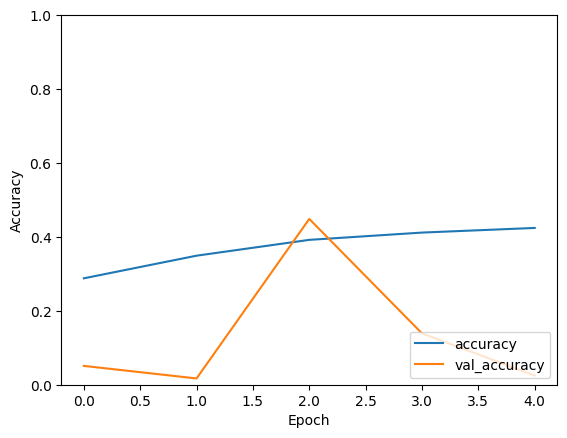

In [91]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
# Save the final model
final_model.save('best_hyperparameters_first_try.h5')

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)